<a href="https://colab.research.google.com/github/NishadHarsh/GRU_TFP/blob/main/GRU_TFP_same.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/My Drive/traffic.csv"
data = pd.read_csv(file_path)
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

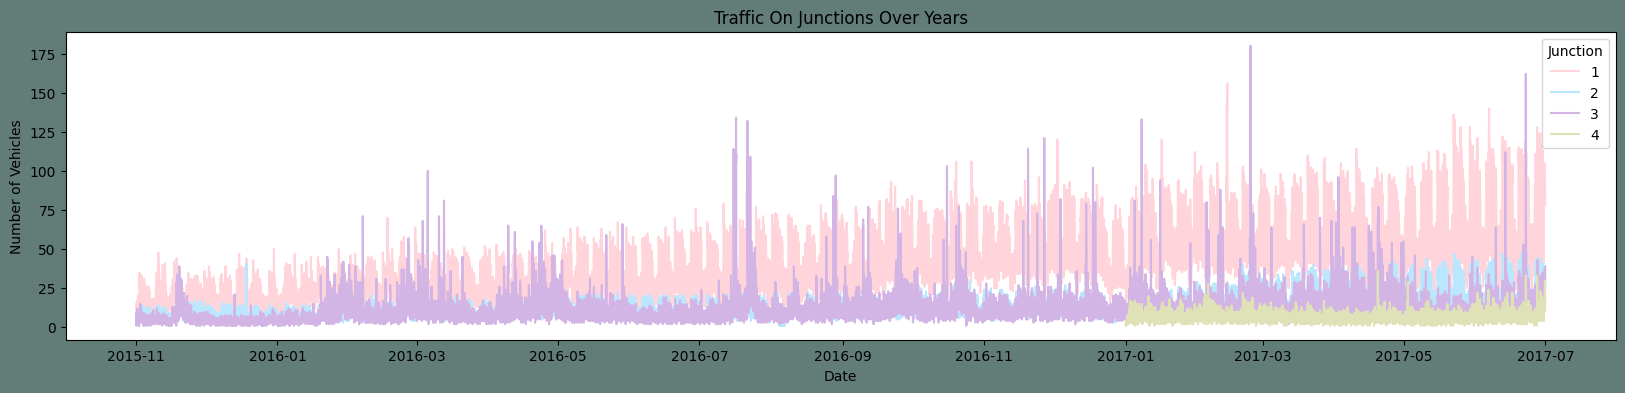

In [ ]:
#df to be used for EDA
df=data.copy()
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [ ]:
#Exploring more features
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


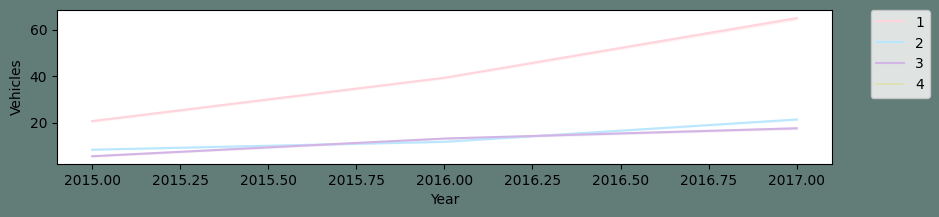

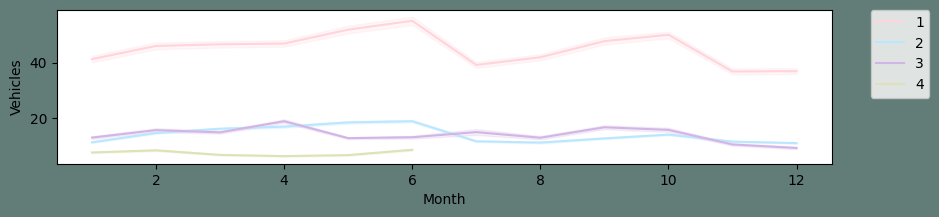

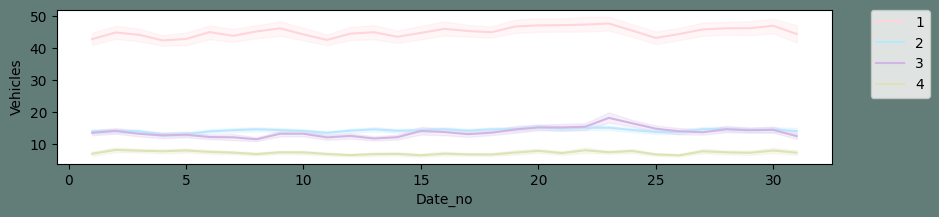

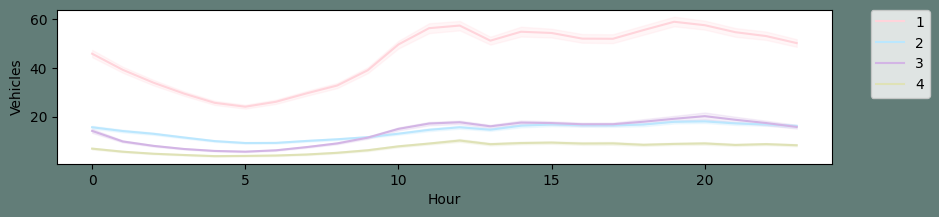

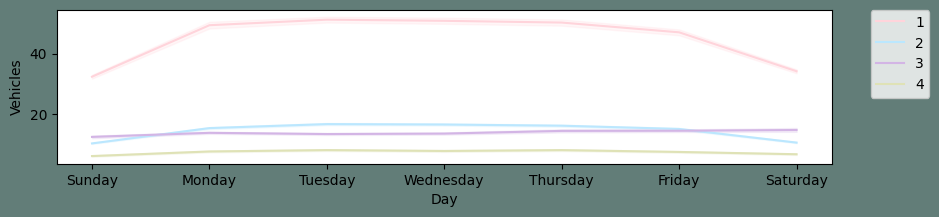

In [ ]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

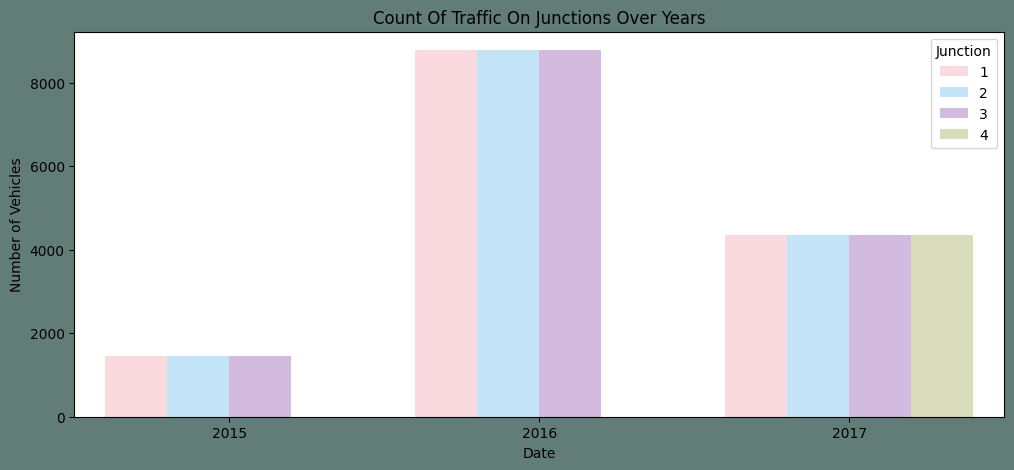

In [ ]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

In [ ]:
corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

ValueError: could not convert string to float: 'Sunday'

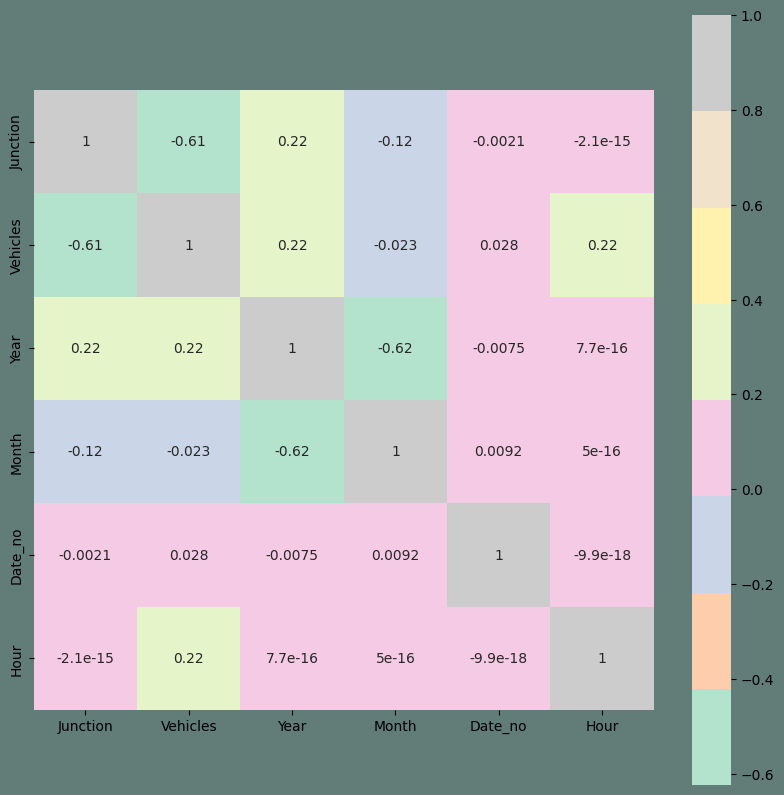

In [ ]:
## This is a additional code.
# Convert categorical columns to numeric (if needed) or drop them
df_numeric = df.select_dtypes(include=['number'])

# Compute correlation matrix
corrmat = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(10, 10), facecolor="#627D78")
sns.heatmap(corrmat, cmap="Pastel2", annot=True, square=True)

plt.show()

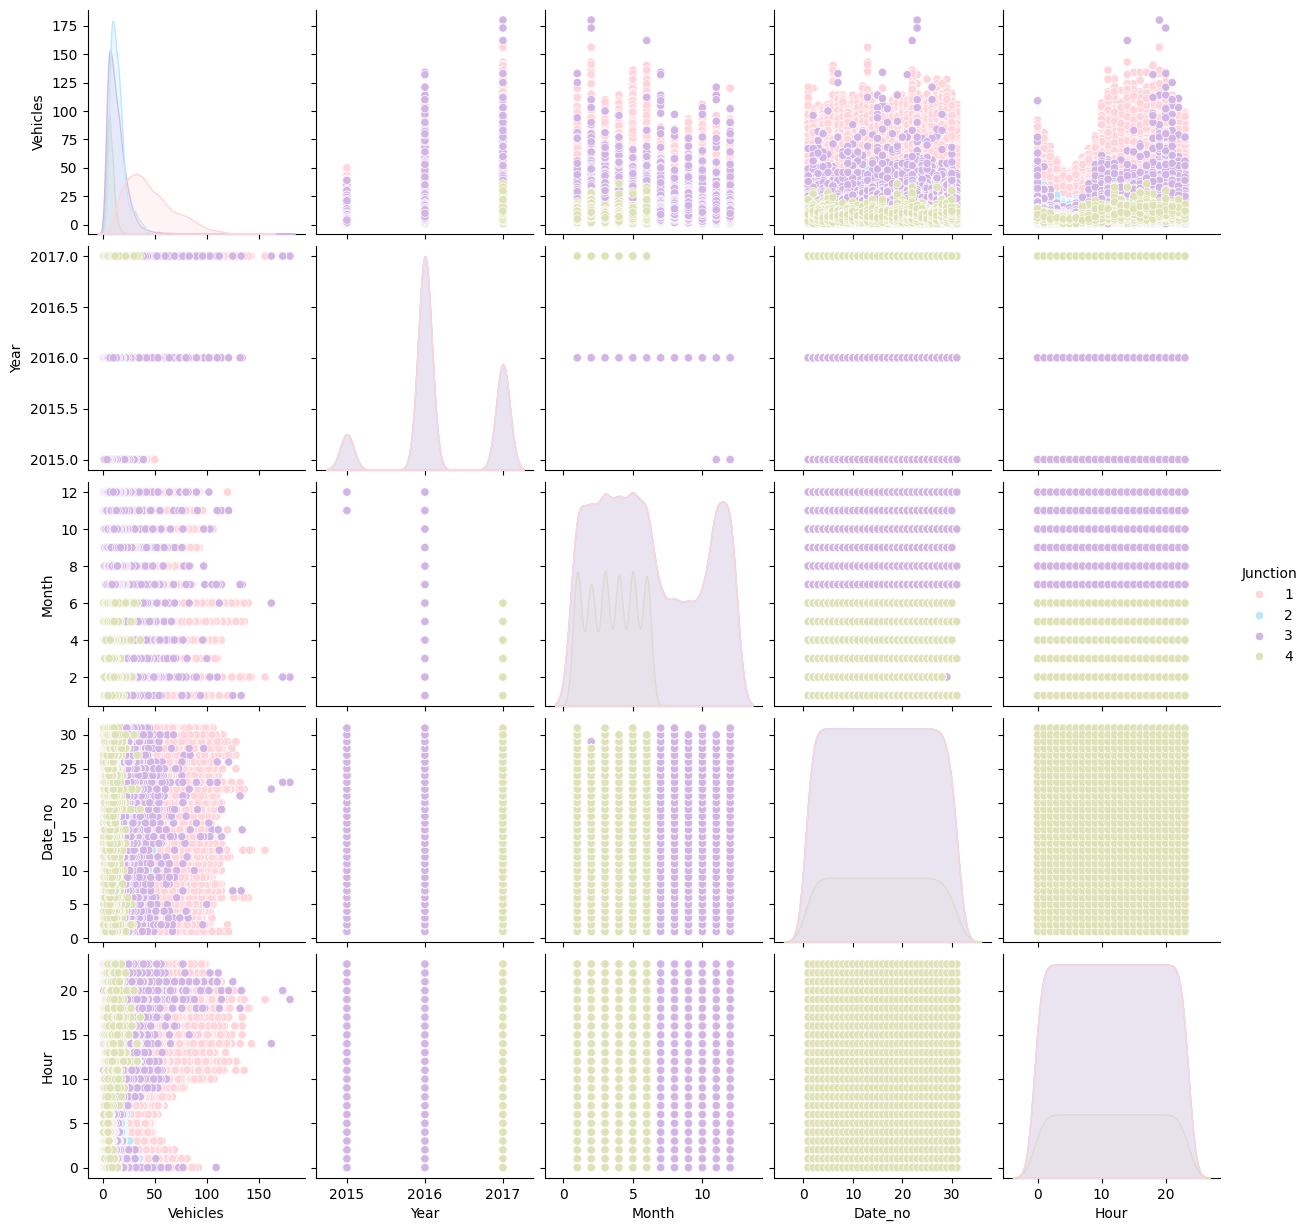

In [ ]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

In [ ]:
#Pivoting data fron junction
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

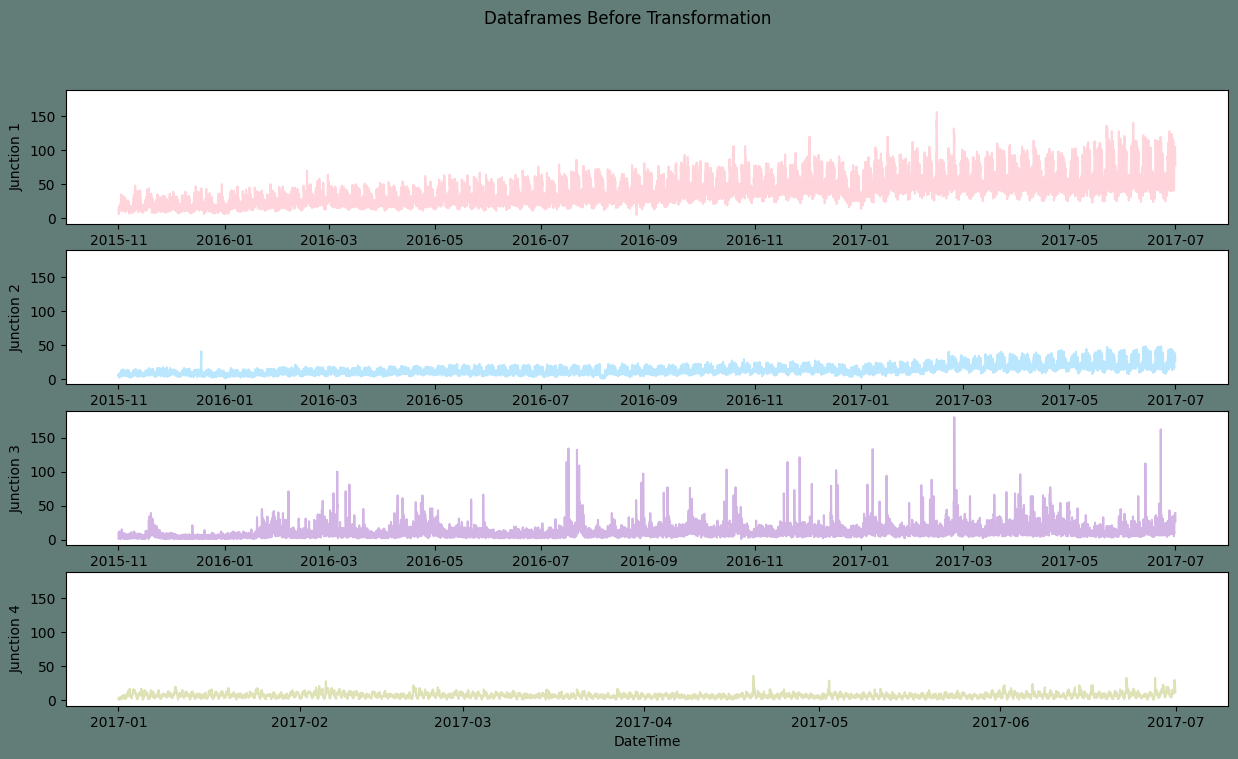

In [ ]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")


#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

In [ ]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [ ]:
#Normalizing and Differencing to make the series stationary
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

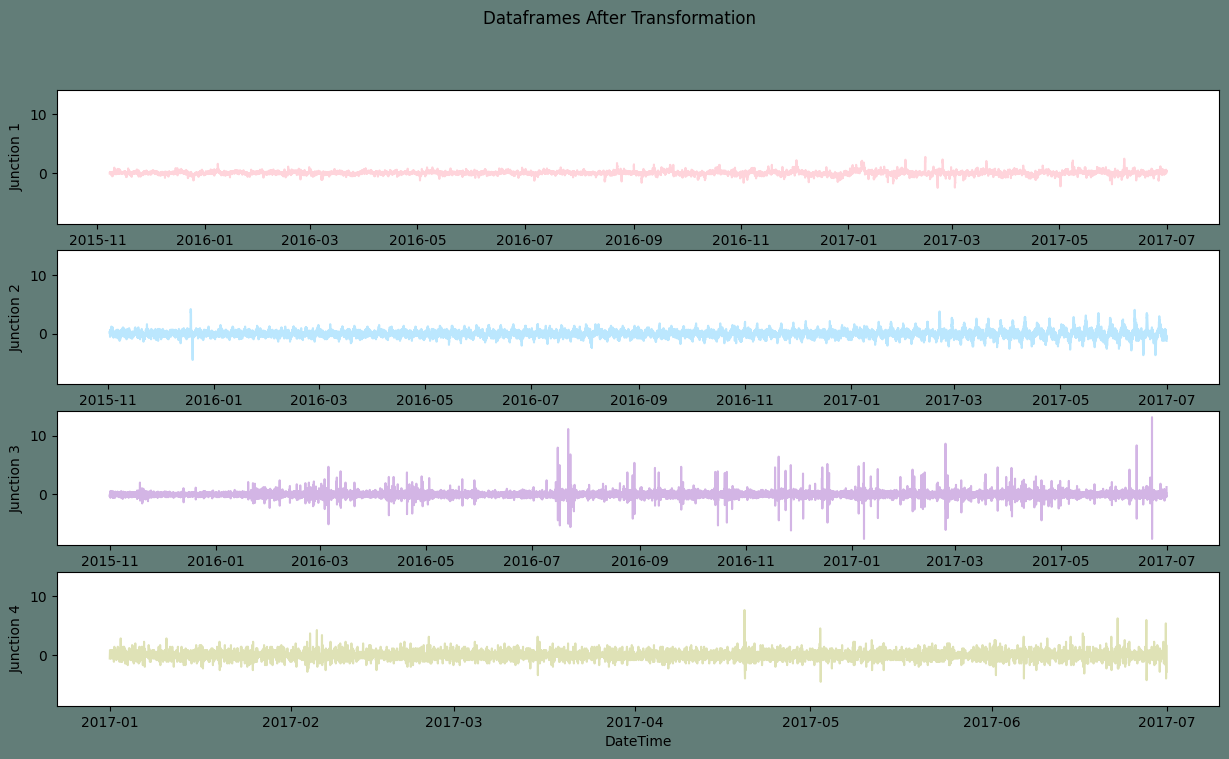

In [ ]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

In [ ]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")


#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415434
p-value: 4.798539876396819e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940144
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832977
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052305
p-value: 2.7787875325953405e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [ ]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

In [ ]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!

    #The GRU model
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [ ]:
#Predictions For First Junction
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 55s 486ms/step - loss: 0.0897
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 82s 491ms/step - loss: 0.0648
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 83s 502ms/step - loss: 0.0633
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 80s 480ms/step - loss: 0.0632
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 85s 516ms/step - loss: 0.0603
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 79s 477ms/step - loss: 0.0605
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 82s 477ms/step - loss: 0.0568
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 481ms/step - loss: 0.0610
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 82s 475ms/step - loss: 0.0602
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 81s 462ms/step - loss: 0.0547
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 465ms/step - loss: 0.0542
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 477ms/step - loss: 0.0556
Epoch 13/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 480ms/step - loss: 0.0550
Epoch 14/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 82s 475ms/step - loss: 0.0541
Epoch 15/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 81s 

The root mean squared error is 0.24726193136575159.


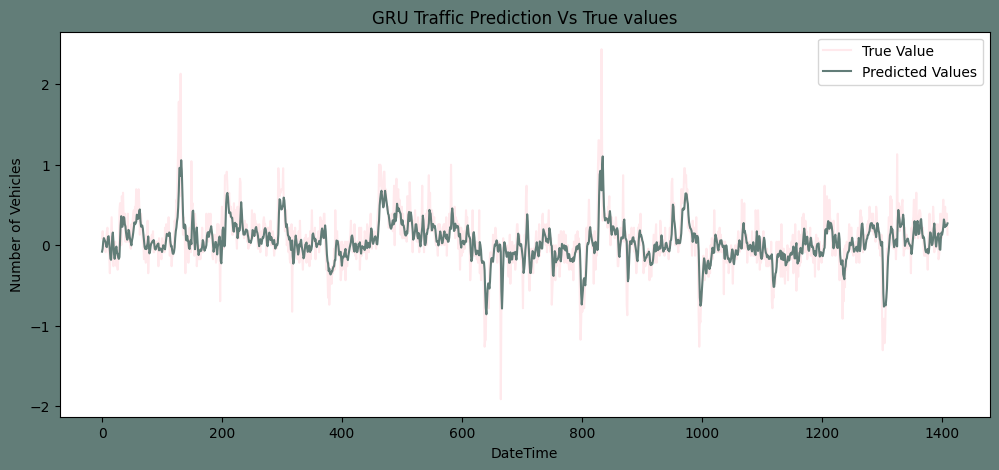

In [ ]:
#Results for J1
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

In [ ]:
#Predictions For Second Junction
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 50s 478ms/step - loss: 0.2580
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 464ms/step - loss: 0.2040
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 467ms/step - loss: 0.1975
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 479ms/step - loss: 0.1922
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 466ms/step - loss: 0.1935
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 480ms/step - loss: 0.1925
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 479ms/step - loss: 0.1843
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 478ms/step - loss: 0.1896
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 477ms/step - loss: 0.1869
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 479ms/step - loss: 0.1878
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 477ms/step - loss: 0.1893
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 478ms/step - loss: 0.1920
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 480ms/step - loss: 0.1908
Epoch 14/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 476ms/step - loss: 0.1834
Epoch 15/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 

The root mean squared error is 0.5553231009079723.


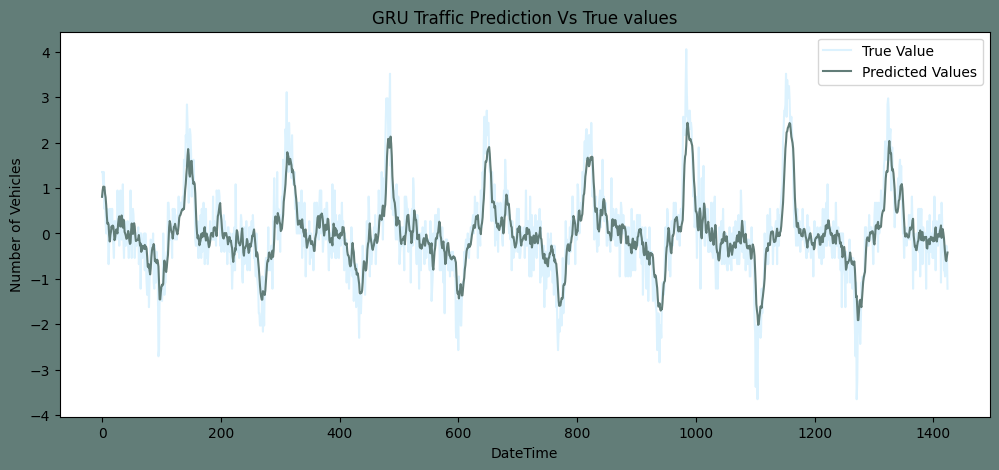

In [ ]:
#Results for J2
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

In [28]:
#Predictions For Third Junction
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 50s 470ms/step - loss: 0.3164
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 480ms/step - loss: 0.3192
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 471ms/step - loss: 0.3206
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 481ms/step - loss: 0.3011
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 483ms/step - loss: 0.2743
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 481ms/step - loss: 0.2490
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 484ms/step - loss: 0.3088
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 485ms/step - loss: 0.2847
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 481ms/step - loss: 0.3058
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 474ms/step - loss: 0.2699
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 482ms/step - loss: 0.3075
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 480ms/step - loss: 0.2984
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 481ms/step - loss: 0.2905
Epoch 14/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 483ms/step - loss: 0.2802
Epoch 15/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 

The root mean squared error is 0.6070060828502278.


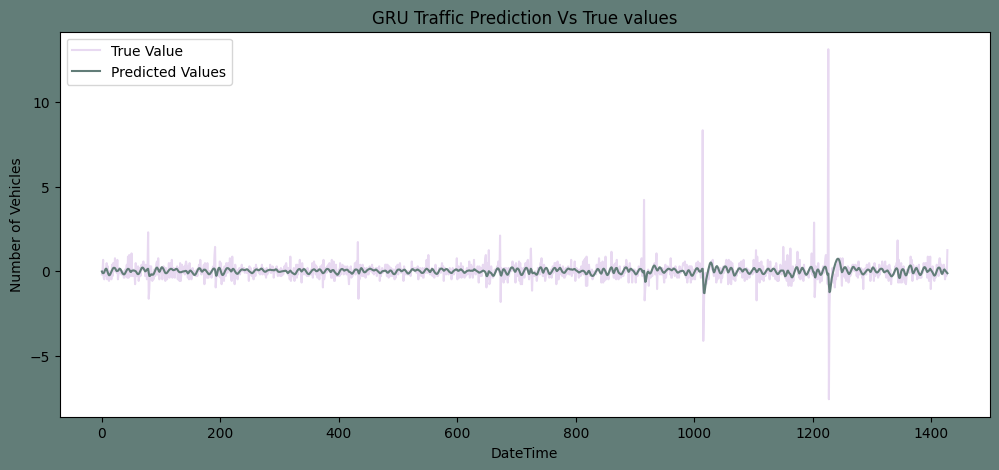

In [29]:
#Results for J3
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)

In [30]:
#Predictions For Forth Junction
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 487ms/step - loss: 0.6786
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 486ms/step - loss: 0.6897
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 491ms/step - loss: 0.6735
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 485ms/step - loss: 0.6814
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 488ms/step - loss: 0.6666
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 487ms/step - loss: 0.7380
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 474ms/step - loss: 0.6708
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 490ms/step - loss: 0.6826
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 489ms/step - loss: 0.6519
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 486ms/step - loss: 0.6675
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 494ms/step - loss: 0.6867
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 485ms/step - loss: 0.6712
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 491ms/step - loss: 0.6422
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 491ms/step - loss: 0.7388
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 

In [ ]:
#Results for J4
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

In [ ]:
#Initialise data of lists for error values of four junctions.
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]
RMSE = [RMSE_J1, RMSE_J2, RMSE_J3, RMSE_J4]
list_of_tuples = list(zip(Junctions, RMSE))
# Creates pandas DataFrame.
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE"])
Results.style.background_gradient(cmap="Pastel1")


In [33]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)

    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")

    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

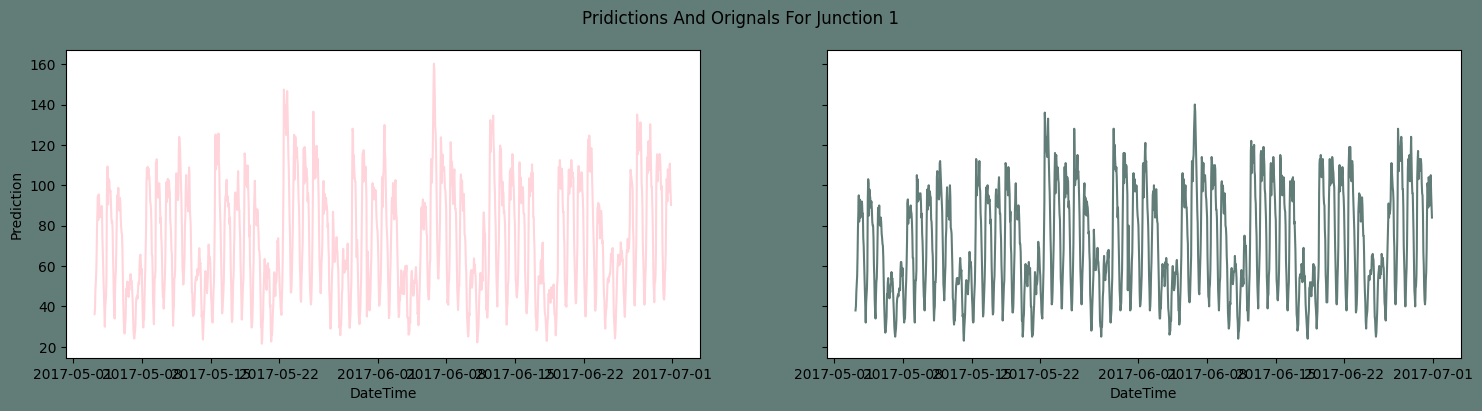

In [34]:
# invert the differenced forecast for Junction 1
recover1 = df_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with orignals
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)

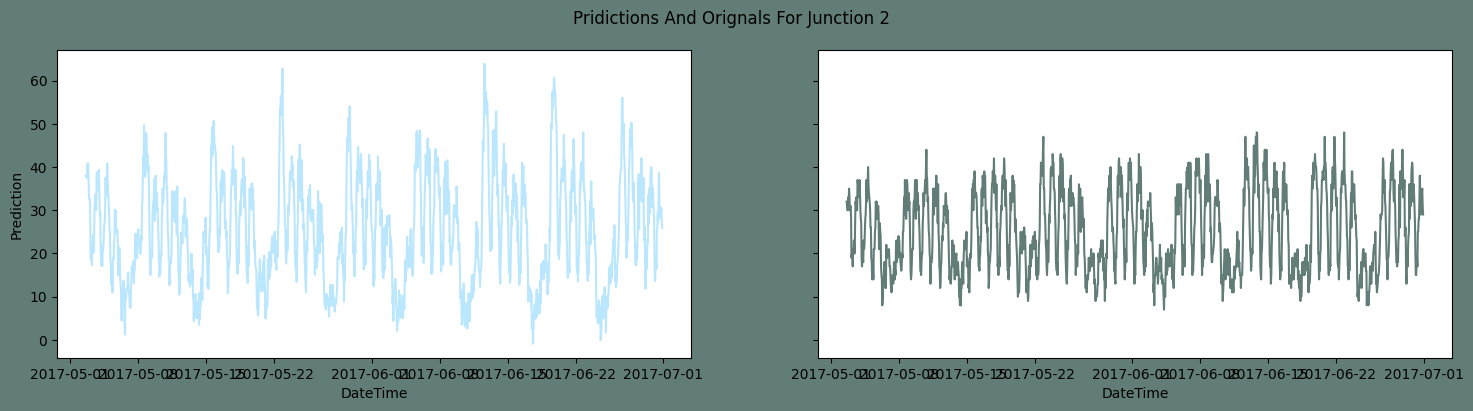

In [35]:
#Invert the differenced J2
recover2 = df_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with orignals
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

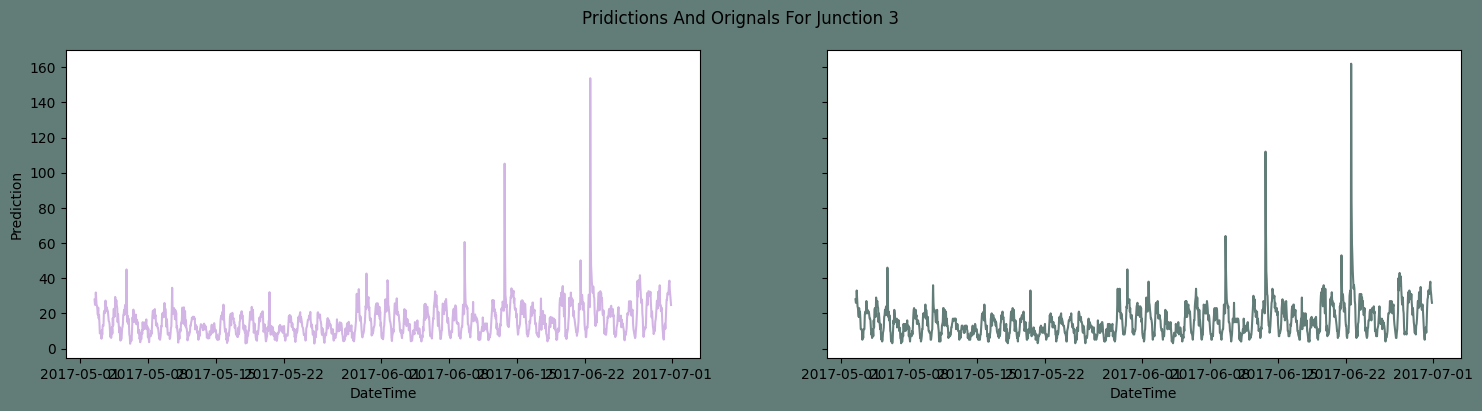

In [36]:
#Invert the differenced J3
recover3 = df_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

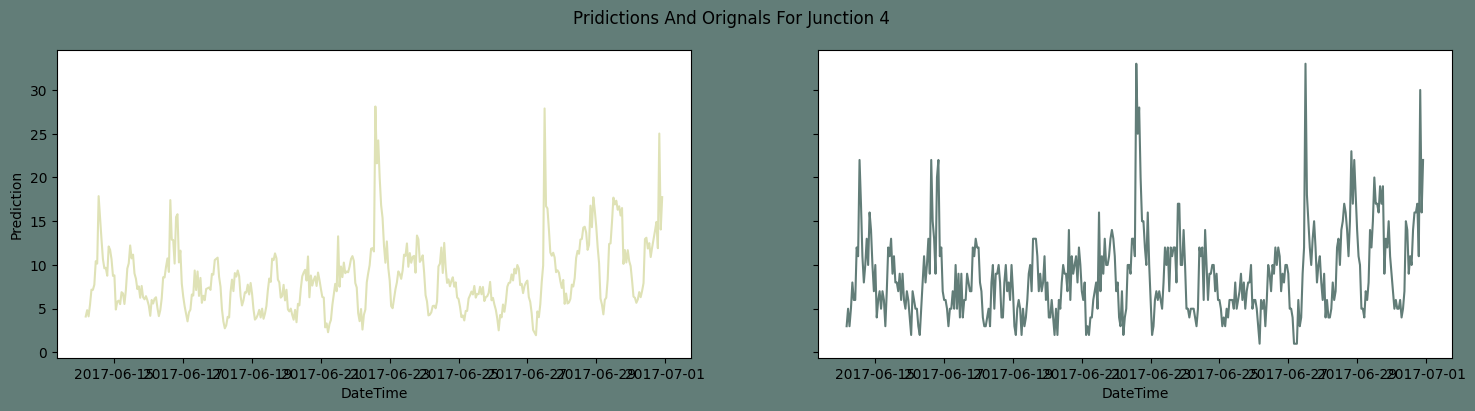

In [37]:
#Invert the differenced J4
recover4 = df_N4.Norm[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)